In this report we will discuss and test Markov switching approach in Time Series analysis

# Markov (auto-)regression

The discussed method employes hidden Markov model (HMM) and will be called Markov (auto-)regression following the documentation of Statsmodels api. The method assumes that there are several unobserved regimes which switch randomly and the switching satisfies the Markov property.

The regime at moment $t$ is represented as $S_t$, a finite-state Markov chain taking value in $𝐒=\{1,2,\dots,m\}$, where $m$ is the number of possible regimes. For each natural $t$ and for any states $i,j,i_1,\dots,i_{t-1} \in 𝐒$ the following equation holds

$$P(S_t = j|S_{t-1}=i,S_{t-2}=i_1,\dots, S_0 = i_{t-1}) = P(S_t=j|S_{t-1}=i) = p_{i j}.$$

For each regime the serie follows a multivariate linear model with parameters dependent on the regime. 

$$Y(t) = μ^{(S_t)} + \beta^{(S_t)} t +\alpha_1^{(S_t)}  Y(t-1)+\dots+\alpha_p^{(S_t)}  Y(t-p)+ b_1^{(S_t)}  X_1(t)+\dots+b_k^{(S_t)}  X_k(t) + \sigma^{(S_t)} \varepsilon _t,$$

where $\mu$ denotes intercept, $\beta$ is the trend coefficient, $X_i$ are exogenous regressors, $\varepsilon_t$ are i.i.d. standard normal r.v-s.


The parameters (coefficients of the linear model, variance of errors and switching probabilities) are estimated using likelihood maximisation.

Source: https://www.statsmodels.org/devel/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html

In [ ]:
###SIMULATION
import sys
!{sys.executable} -m pip install PyDTMC
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pydtmc
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression as MarkovAR
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.metrics import mean_squared_error as MSE

We use PyDTMC module to simulate a 2-state Markov chain with the given switching probabilities.

Source: https://github.com/TommasoBelluzzo/PyDTMC

The first simulated time serie is described as follows.

$Y(t)= μ + \beta t +b_1 X_1(t)+b_2  X_2(t)+b_3 X_3(t) + \sigma\varepsilon _t,$

$\mu = \mu^{S(t)},\beta = \beta^{S(t)},b = b^{S(t)},\sigma = const$,

$𝐒 = \{1,2\}$ is the regime space, $𝐏=(p_{i j})\in 𝗥^{2\times 2}$ is the switching probabilities matrix

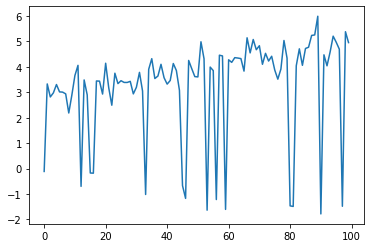

In [ ]:
np.random.seed(seed=1000)
n = 100
k = 3#number of exogenous regressors
sigma2 = 0.01
mu = [3, 0] ## intercept
beta = [0.02,-0.02]#[0.2,-0.3] ## trend
states = ['0','1']
P = [[0.9,0.1],
     [0.8,0.2]]
B = [np.array([[0.2],[-0.2],[0.3]]),np.array([[-0.2],[0],[0.3]])]

mc = pydtmc.MarkovChain(P, states)
S = [int(s) for s in mc.walk(n)]
X = stats.norm.rvs(0,1,size=(n,k))
eps = stats.norm.rvs(0,1,size=n)
Y = np.array([mu[S[i]] + beta[S[i]]*i+np.dot(X[i],B[S[i]])[0] for i in range(n)])+eps*sigma2**0.5
plt.plot(Y)
plt.show()

Now we fit the model 

In [ ]:
model = MarkovRegression(Y, exog=X,trend='ct',k_regimes = 2,switching_trend=True, switching_exog=True, switching_variance=False)
res_model = model.fit()
print(res_model.summary())

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                  100
Model:               MarkovRegression   Log Likelihood                  41.820
Date:                Thu, 28 Jul 2022   AIC                            -57.640
Time:                        09:01:18   BIC                            -23.773
Sample:                             0   HQIC                           -43.934
                                - 100                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.070      0.308      0.758      -0.116       0.160
x1            -0.0194      0.001    -17.393      0.0

In [ ]:
#plt.plot(res_model.smoothed_marginal_probabilities[0])
print(res_model.smoothed_marginal_probabilities[1])

MarkovRegression performed well in parameter estimation. However the maximization algorithm might not converge (as in the following example) quite often as the likelihood induced surface is likely to have singularities, discontinuity points and local extremas.

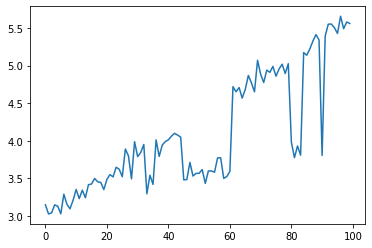

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1144: RuntimeWarning: divide by zero encountered in log
  return np.log(results[5])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1757: RuntimeWarning: divide by zero encountered in log
  self.llf_obs = np.log(self.joint_likelihoods)


LinAlgError: ignored

In [ ]:
np.random.seed(seed=1000)
sigma2 = 0.01
mu1 = [3, 3]
beta1 = [.02,.02]
states = ['0','1']
P1 = [[0.93,0.07],
     [0.1,0.9]]
B1 = [np.array([[0.2],[-0.2]]),np.array([[-0.3],[0]])]

mc1 = pydtmc.MarkovChain(P1, states)
S1 = [int(s) for s in mc1.walk(n)]
X1 = stats.norm.rvs(0,0.1,size=(n,2))+np.array([[0.03*i for i in range(n)],[0 for i in range(n)]]).transpose()
eps = stats.norm.rvs(0,1,size=n)
Y1 = np.array([mu1[S1[i]] + beta1[S1[i]]*i+np.dot(X1[i],B1[S1[i]])[0] for i in range(n)])+eps*sigma2**0.5
plt.plot(Y1)
plt.show()
model1 = MarkovRegression(Y1,order=1, exog=X1,trend='ct',k_regimes = 2,switching_trend=False, switching_exog=True, switching_variance=False)
res_model1 = model1.fit()
print(res_model1.summary())

We'd like to see how the successfully fitted model can forecast out of train sample.
Unfortunately the statsmodels MarkovRegression and MarkovAutoregression are not provided with tools for prediction with exogenous variables. So we'll have to use statsmodels' OLS with the parameters fitted by MarkovRegression

RMSE for regime 0 0.14667643182194623
RMSE for regime 1 0.1345262875044717


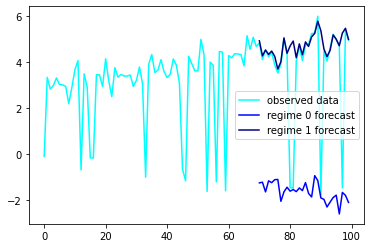

In [ ]:
np.random.seed(seed=1000)

train_part = 0.7
n_params = 5
X_new = np.array([np.append([1,i],X[i]) for i in range(n)])#adding 1 and t in regressors as variables corresponding to intercept and trend
X_train = X_new[:int(n*train_part)]
y_train = Y[:int(n*train_part)]
X_test = X_new[int(n*train_part):]
y_test = Y[int(n*train_part):]

train_model = MarkovRegression(y_train,order=1, exog=X_train,trend='n',k_regimes = 2,switching_trend=True,
                               switching_exog=True, switching_variance=False).fit()#model fitted on train sample
train_params = train_model.params

params_0 = [train_params[2*i] for i in range(1,n_params+1)]#regime 0 parameters
params_1 = [train_params[2*i+1] for i in range(1,n_params+1)]#regime 1 parameters
pred_model=sm.OLS(endog=y_train,exog=X_train)#predicting model
y_pred_0=pred_model.predict(params=params_0,exog=X_test)#passing MarkovRegression parameters to OLS
y_pred_1=pred_model.predict(params=params_1,exog=X_test)
plt.plot(Y,color='cyan',label='observed data')
plt.plot(range(int(n*train_part),n),y_pred_0,color='b',label='regime 0 forecast')
plt.plot(range(int(n*train_part),n),y_pred_1,color='navy',label='regime 1 forecast')
plt.legend()
index_0 = [i for i in range(n-int(n*train_part)) if S[i+int(n*train_part)]==1]
index_1 = [i for i in range(n-int(n*train_part)) if S[i+int(n*train_part)]==0]

print('RMSE for regime 0',MSE(y_pred_0[index_0],y_test[index_0],squared=False))
print('RMSE for regime 1',MSE(y_pred_1[index_1],y_test[index_1],squared=False))

The model seems to predict well the value conditioned on the regime.

One may wonder whether we can use Markov regression for time series with non-markovian regime switching.
In the following example the series turns to regime 1 if and only if the index of the observation equals 0 modulo 10.

$S_t = 1$ if $t≡ 0 ($mod $ 10)$,

$S_t = 0$ otherwise.

However Markov regression still works well.

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                  100
Model:               MarkovRegression   Log Likelihood                  67.378
Date:                Tue, 19 Jul 2022   AIC                           -108.755
Time:                        14:50:48   BIC                            -74.888
Sample:                             0   HQIC                           -95.049
                                - 100                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1236      0.091      1.363      0.173      -0.054       0.301
x1            -0.0214      0.001    -15.822      0.0

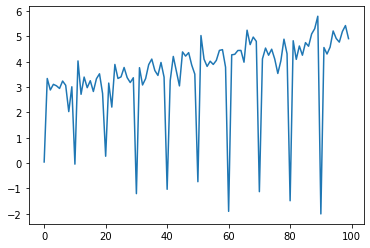

In [ ]:
S = list(map(lambda i:int(i%10==0),range(n)))
sigma2 = 0.01
mu = [3, 0] ## mean value
beta = [0.02,-0.02]#[0.2,-0.3] ## intercept
B = [np.array([[0.2],[-0.2],[0.3]]),np.array([[-0.2],[0],[0.3]])]

Y2 = np.array([mu[S[i]] + beta[S[i]]*i+np.dot(X[i],B[S[i]])[0] for i in range(n)])+eps*sigma2**0.5
plt.plot(Y2)
model2 = MarkovRegression(Y2,order=1, exog=X,trend='ct',k_regimes = 2,switching_trend=True, switching_exog=True, switching_variance=False)
res_model2 = model2.fit()
print(res_model2.summary())

The end